<a href="https://colab.research.google.com/github/dwarcy/TopicosEspeciais_IA/blob/main/aula4_Finetune_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 4 — Fine-tuning de um Transformer Decoder-only

Nesta prática faremos um **fine-tuning supervisionado (SFT)** em um **decoder-only causal LM** usando o menor modelo *útil* e popular para demos no Hugging Face:

- **Modelo base:** `distilbert/distilgpt2`

Passos:
1. Carregar/definir documentos (toy ou pasta local)
2. Tokenização + *grouping* em blocos (CLM)
3. Fine-tuning com `Trainer`
4. Inferência

In [60]:
# (Opcional) Instalar dependências no ambiente local/Colab
!pip -q install transformers datasets accelerate

In [61]:
import os
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch: 2.9.0+cpu
cuda available: False


## 1) Dataset — Documentos (toy) ou pasta local

### Opção A (didática): documentos toy
### Opção B (real): ler `.txt` de uma pasta local

> Para aula, a Opção A roda rápido e mostra o pipeline completo.


In [ ]:
# Opção A: documentos toy
docs = [
    "UFU forma estudantes de IA aplicada para muitas áreas.",
    "Um transformer decoder-only prevê o próximo token com auto-regressão.",
    "Fine-tuning ajusta um modelo pré-treinado para um domínio específico.",
    "Temperatura controla aleatoriedade; top-k e top-p controlam o corte do vocabulário.",
    "A Universidade Federal de Uberlândia é top demais.",
    "A Universidade Federal de Uberlândia é top demais mesmo."
]

ds = Dataset.from_dict({"text": docs}).train_test_split(test_size=0.1, seed=42)
ds

In [76]:
# Opção A: documentos toy
docs = [
    "UFU trains students in applied AI for many areas.",
    "A decoder-only transformer predicts the next token using autoregression.",
    "Fine-tuning adjusts a pre-trained model for a specific domain.",
    "Temperature controls randomness; top-k and top-p control vocabulary clipping.",
    "The Federal University of Uberlândia is amazing.",
    "The Federal University of Uberlândia is really amazing.",
]

ds = Dataset.from_dict({"text": docs}).train_test_split(test_size=0.1, seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 5
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [ ]:
# Opção B (descomente se quiser ler arquivos .txt de uma pasta):
# from glob import glob
# paths = glob("./meus_docs/*.txt")
# docs = [open(p, "r", encoding="utf-8").read() for p in paths]
# ds = Dataset.from_dict({"text": docs}).train_test_split(test_size=0.1, seed=42)
# ds

## 2) Tokenizer + Modelo base

Usaremos o tokenizer do modelo base e definiremos `pad_token`, pois GPT-2 não tem por padrão.


In [77]:
model_id = "distilbert/distilgpt2"

tok = AutoTokenizer.from_pretrained(model_id)

# GPT-2 não define pad_token por padrão; necessário para batches com padding
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

print("Vocab size:", len(tok))
print("Model loaded:", model_id)

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilbert/distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vocab size: 50257
Model loaded: distilbert/distilgpt2


## 3) Tokenização + agrupamento em blocos (Causal LM)

Em *Causal Language Modeling*, a label é o próprio `input_ids` deslocado internamente pelo modelo.
Uma forma padrão é concatenar tudo e quebrar em blocos fixos (`block_size`).


In [78]:
block_size = 64  # pequeno para rodar rápido

def tokenize_fn(batch):
    return tok(batch["text"], truncation=True)

tok_ds = ds.map(tokenize_fn, batched=False, remove_columns=["text"])

def group_texts(examples):
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated["input_ids"])
    print('total_len = ', total_length)
    total_length = (total_length // block_size) * block_size
    print('total_len = ', total_length)
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_ds = tok_ds.map(group_texts, batched=True)
collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

total_len =  66
total_len =  64


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

total_len =  16
total_len =  0


## Inferência Antes do Fine Tuning

In [80]:
model.eval()

prompt=tok("UFU ", return_tensors = "pt", truncation = True).input_ids[0,]
inputs = prompt.unsqueeze(0).to(device)
with torch.no_grad():
    out_ids = model.generate(
        inputs,
        max_new_tokens=10,
        do_sample=True,
        pad_token_id=tok.eos_token_id,
        temperature= 0.7,
        top_k = 50,
        top_p = 1.0
    )
print(f"Inference: {tok.decode(out_ids[0])}")

Inference: UFU ipsum










## 4) Fine-tuning (SFT) com `Trainer`

> Com o seguinte código, abstraímos a parte do treino e executar 10 épocas para o modelo aprender o conteúdo do novo corpus.


In [81]:
args = TrainingArguments(
    output_dir="./ft_tiny_gpt2",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    learning_rate=5e-4,
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=lm_ds["train"],
    eval_dataset=lm_ds["test"],
    data_collator=collator
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,4.858553,No log
2,3.011231,No log
3,1.477365,No log
4,0.623008,No log
5,0.214867,No log
6,0.135228,No log
7,0.078033,No log
8,0.061263,No log
9,0.051148,No log
10,0.030401,No log


TrainOutput(global_step=10, training_loss=1.0541097823530436, metrics={'train_runtime': 14.058, 'train_samples_per_second': 0.711, 'train_steps_per_second': 0.711, 'total_flos': 163310469120.0, 'train_loss': 1.0541097823530436, 'epoch': 10.0})

## 5) Inferência depos do finetune



In [82]:
prompt=tok("UFU ", return_tensors = "pt", truncation = True).input_ids[0,]
inputs = prompt.unsqueeze(0).to(device)
with torch.no_grad():
    out_ids = model.generate(
        inputs,
        max_new_tokens=10,
        do_sample=True,
        pad_token_id=tok.eos_token_id,
        temperature= 0.7,
        top_k = 50,
        top_p = 1.0
    )
print(f"Inference: {tok.decode(out_ids[0])}")

Inference: UFU ipsia is really amazing.The Federal University of


In [59]:
print("\n--- Inferência em Documentos de Treino ---")
train_docs = ds['train']['text']

for i, doc_text in enumerate(train_docs):
    initial_tokens = tok(doc_text, return_tensors="pt", truncation=True).input_ids[0, :10]
    inputs = initial_tokens.unsqueeze(0).to(device) # unsqueeze to add batch dimension

    with torch.no_grad():
        out_ids = model.generate(
            inputs,
            max_new_tokens=10,
            do_sample=True,
            pad_token_id=tok.eos_token_id,
            temperature= 0.7,
            top_k = 50,
            top_p = 1.0
        )

    # Decode the sequence
    prompt_text = tok.decode(initial_tokens, skip_special_tokens=True)
    generated_text = tok.decode(out_ids[0], skip_special_tokens=True)
    print(f"doc{i}: {prompt_text}*{generated_text[len(prompt_text):]}*")



--- Inferência em Documentos de Treino ---
doc0: Fine-tuning adjusts a pre-trained model* for a specific domain.The Federal University of Uber*
doc1: The Federal University of Uberlândia is* really amazing.The Federal University of Uberlâ*
doc2: The Federal University of Uberlândia is* really amazing.The Federal University of Uberlâ*
doc3: A decoder-only transformer predicts the next token* using autoregression.The Federal University of Uber*
doc4: UFU trains students in applied AI for many areas*.The Federal University of Uberlândia*


# Exercício prático

Escolha um prompt que não estava nos dados de treino, mas que seja do mesmo domínio. Faça comparações. Documente a saída do modelo base (sem treino) e do modelo ajustado. Verifique se o modelo "aprendeu" termos técnicos ou o vocabulário específico que você forneceu nos arquivos .txt.

#Comparação entre Modelo Base e Ajustado

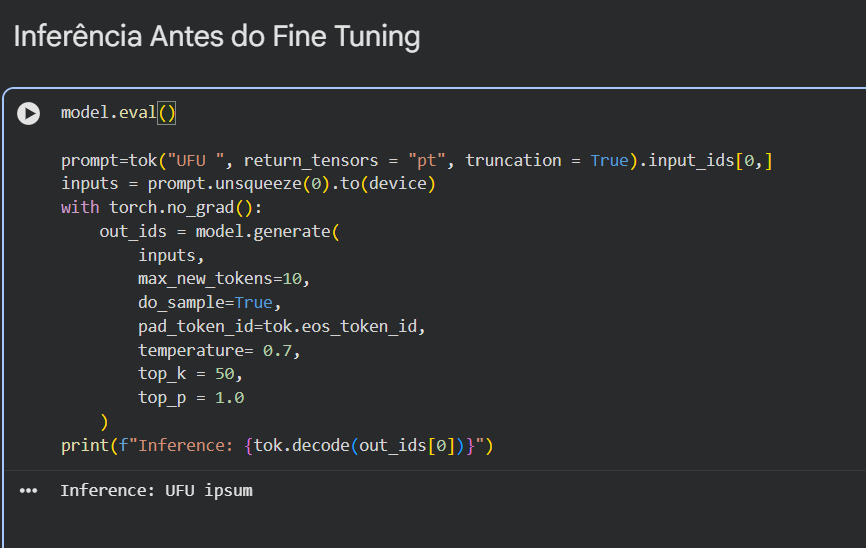

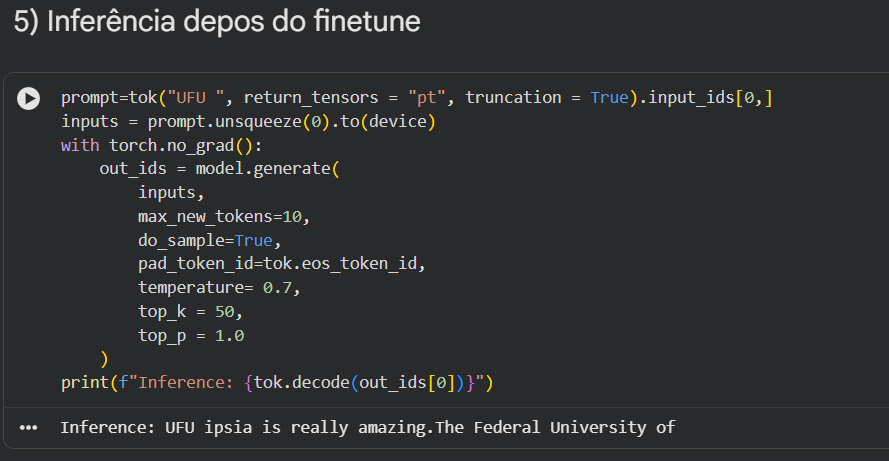